# MST698S CNN EXERCISE
##### By Amil Arthur & Antonella Sciortino  

In [1]:
#Import Libraries
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
torch.set_grad_enabled(True)
torch.set_printoptions(linewidth =120) 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# Build CNN Model using Pytorch
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

In [3]:
#Download FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
# Instantiate CNN  
network = Network()

#Load images into batches
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader)) # Getting a batch
images, labels = batch

In [5]:
preds = network(images)
loss = F.cross_entropy(preds, labels) # Calculating the loss
 
loss.item()

# Function to get preditions 
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
 
get_num_correct(preds, labels)

#Calculating the Gradients
network.conv1.weight.grad
loss.backward() 
network.conv1.weight.grad.shape
 
#Updating the Weights
optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step() 
 
preds = network(images)
loss.item()

2.3004541397094727

In [6]:
#Calculate & update Loss
 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)
 
# Get Batch    
batch = next(iter(train_loader)) 
images, labels = batch
 
preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

# Calculate Gradients & Update Weights
loss.backward() 
optimizer.step() 
 
print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.2738230228424072
loss2: 2.190732479095459


In [7]:
# Train Model 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)
 
for epoch in range(5):
    
    total_loss = 0
    total_correct = 0

# Get Batch    
    for batch in train_loader: 
        images, labels = batch 
 
        preds = network(images) 
        loss = F.cross_entropy(preds, labels) 
 
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step() 
 
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
 
    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 47737 loss: 324.6319432705641
epoch 1 total_correct: 51594 loss: 224.3890337049961
epoch 2 total_correct: 52180 loss: 210.5389592051506
epoch 3 total_correct: 52697 loss: 197.26957465708256
epoch 4 total_correct: 52960 loss: 189.20001480728388


In [8]:
# Places model into eval mode for testing 
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
 
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

preds_correct = get_num_correct(train_preds, train_set.targets)
 
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 52743
accuracy: 0.87905


In [9]:
#Generate Confusion Matrix for all 10 Classes 
train_set.targets
train_preds.argmax(dim=1)

stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)
 
stacked.shape

cmt = torch.zeros(10,10, dtype=torch.int64)
cmt

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

cmt

tensor([[5411,   37,   81,  106,   12,    1,  324,    1,   27,    0],
        [  17, 5915,    3,   50,    1,    1,    4,    0,    9,    0],
        [  79,   15, 4726,   70,  797,    1,  264,    0,   48,    0],
        [ 237,  206,   20, 5322,   49,    1,  152,    1,   12,    0],
        [  10,   46,  320,  499, 4773,    0,  291,    0,   61,    0],
        [   5,    4,    0,    4,    0, 5822,    0,  121,   11,   33],
        [1117,   23,  564,  188,  580,    0, 3450,    0,   78,    0],
        [   1,    0,    0,    1,    0,   49,    0, 5858,    2,   89],
        [  44,   15,   19,   33,   11,    9,   27,    9, 5832,    1],
        [   1,    0,    0,    2,    0,   37,    0,  323,    3, 5634]])

Confusion matrix, without normalization
tensor([[5411,   37,   81,  106,   12,    1,  324,    1,   27,    0],
        [  17, 5915,    3,   50,    1,    1,    4,    0,    9,    0],
        [  79,   15, 4726,   70,  797,    1,  264,    0,   48,    0],
        [ 237,  206,   20, 5322,   49,    1,  152,    1,   12,    0],
        [  10,   46,  320,  499, 4773,    0,  291,    0,   61,    0],
        [   5,    4,    0,    4,    0, 5822,    0,  121,   11,   33],
        [1117,   23,  564,  188,  580,    0, 3450,    0,   78,    0],
        [   1,    0,    0,    1,    0,   49,    0, 5858,    2,   89],
        [  44,   15,   19,   33,   11,    9,   27,    9, 5832,    1],
        [   1,    0,    0,    2,    0,   37,    0,  323,    3, 5634]])


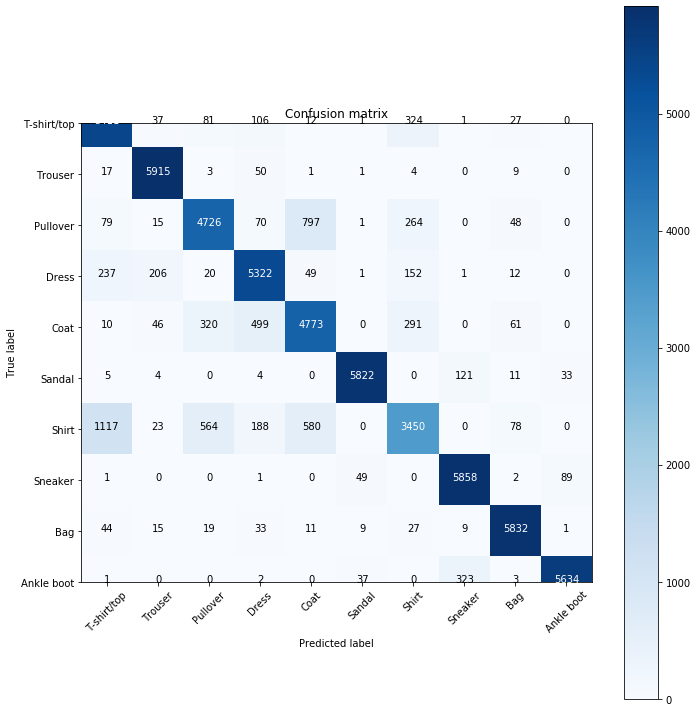

In [10]:
# Graph Matrix with heatmap 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmt, names)

In [11]:
#Derive Stats for each class from confusion matrix
Class_FP = cmt.sum(axis=0) - np.diag(cmt) 
Class_FN = cmt.sum(axis=1) - np.diag(cmt)
Class_TP = np.diag(cmt)
Class_TN = cmt.sum() - (Class_FP + Class_FN + Class_TP)


In [15]:
#Convert Tensors to Numpy array
Class_FP = Class_FP.numpy()
Class_FN = Class_FN.numpy()
Class_TN = Class_TN.numpy()


In [ ]:
#Print statistic for each class
print (Class_FP)
print (Class_FN)
print (Class_TP)
print (Class_TN)


In [21]:
# Takes average for all classes & gets Stats for entire model  
TN_Sum = 0
FN_Sum = 0
TP_Sum = 0
FP_Sum = 0
     

for i in range(0, len(Class_TN)):    
    TN_Sum = TN_Sum + Class_TN[i];  

TN = TN_Sum/10     

for i in range(0, len(Class_FN)):    
    FN_Sum = FN_Sum + Class_FN[i];  

FN = FN_Sum/10  

for i in range(0, len(Class_TP)):    
    TP_Sum = TP_Sum + Class_TP[i];  

TP = TP_Sum/10  

for i in range(0, len(Class_FP)):    
    FP_Sum = FP_Sum + Class_FP[i];  

FP = FP_Sum/10  

print(TN);   
print(FN);
print(TP);
print(FP);

53274.3
725.7
5274.3
725.7


In [23]:
#Cohen's Kappa formula 
Po = (TN + TP)/ (FP + TN + FN + TP)
Pyes = (TP + FN)/(FP + TN + FN + TP) * (((TP + FP)/(FP + TN + FN + TP)))
Pno = (FP + TN)/(FP + TN + FN + TP) * (((FN + TN)/(FP + TN + FN + TP)))
Pe = Pyes + Pno
K = (Po - Pe) /(1 - Pe)


In [24]:
#Print Cohen's Kappa score
print (K)

0.8656111111111114


## 1. Describe other ways that image classifiers could be used to streamline data sorting?

A couple ways that image classifiers can be used to streamline data sorting is through Keras and TensorFlow.  TensorFlow and Keras are both Python libraries that use numerical computation and data flow graphs to do machine learning and deep neural networks research.  Keras allows for data to be collected and separated in certain classes. For example, different types of flowers (i.e. roses, dandelions, tulips, etc…) or fruits (i.e. apples, oranges, pears, etc..). The data can come from anywhere such as Satellite, Google, Kaggle, Yandex, and Flickr to name a few.  Analysts can use image classification for analysis and geoprocessing. One example is through ArcGIS, a cloud-based mapping, analysis and data storage system used to create, share and manage maps, scenes, layers, apps and other geographic content. In ArcGIS, you can perform multidimensional analysis using raster data to research scientific trends and anomalies. In ArcGIS, you can also conduct space analysis through the use of seamless transformation between an image coordination system (ICS) and map coordinate system to display, interpret, collect and edit GIS feature data on respective imagery

## 2. How well does the model perform? Would you deploy this model? Why or Why not?

Our image classifier model to identify Denovian military vehicles in support of the United Nations (U.N.) mission is performing at around 88%; therefore, we will choose to deploy our model.  According to the results in our image classification inference script, we've obtained Cohen’s Kappa formula score of .85, which suggest 'near perfect agreement.'

